In [1]:
import geological_segmentation as geoseg
from SimPEG import maps, utils, data, optimization, maps, regularization, inverse_problem, directives, inversion, data_misfit
import discretize
from discretize.utils import mkvc, refine_tree_xyz
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from pymatsolver import Pardiso as Solver
from SimPEG.electromagnetics.static import resistivity as dc, utils as dcutils
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from scipy.stats import norm
import scipy.sparse as sp
from sklearn.mixture import GaussianMixture
import copy
from SimPEG.utils.code_utils import validate_ndarray_with_shape
# setup the GMMRF
from scipy import spatial, linalg
from segment_anything import sam_model_registry
from segment_anything import SamAutomaticMaskGenerator
from PIL import Image
from scipy import stats
from matplotlib import cm
from scipy.special import logsumexp
from sklearn.mixture._gaussian_mixture import (
    _compute_precision_cholesky,
)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import datetime
import warnings
import random

# Python Version
import sys
print(sys.version)

# Reproducible science
seed = 12345
np.random.seed(seed)

from pathlib import Path

from SimPEG.regularization import (

    PGIsmallness,
)

from scipy.ndimage import laplace

class plot_mref(directives.InversionDirective):

    mesh = None
    
    def initialize(self):
        self.start = 0
        # self.endIter()
    
    def endIter(self):
        # plot
        meshCore = self.mesh
        # predicted = self.invProb.reg.gmmref.predict(self.opt.xc.reshape(-1, 1))
        fig,ax = plt.subplots(3,1,figsize=(15,5))
        mm = meshCore.plot_image(
            self.opt.xc, ax=ax[0],
            # clim=[-np.log(250),-np.log(10),],
            # clim=[0,500],
            pcolor_opts={'cmap':'Spectral'}
        )
        # fig,ax = plt.subplots(1,1,figsize=(15,5))
        mm2 = meshCore.plot_image(
            1 / np.exp(self.invProb.reg.objfcts[0].mref), ax=ax[1],
            # clim=[-np.log(250),-np.log(10),],
            clim=[0,500],
            pcolor_opts={'cmap':'Spectral'}
        )
        # ax.set_xlim([-750,750])
        # ax.set_ylim([-250,0])
        # fig,ax = plt.subplots(1,1,figsize=(15,5))
        # mmpred = meshCore.plot_image(
        #    predicted, ax=ax[3],
        #     # clim=[-np.log(250),-np.log(10),],
        #     pcolor_opts={'cmap':'Spectral'}
        # )
        
        #plt.colorbar(mm[0])
        # utils.plot2Ddata(
        #     meshCore.gridCC,1 / np.exp(mtrue[actcore]),nx=500,ny=500,
        #     contourOpts={'alpha':0},
        #     clim=[0,500],
        #     ax=ax[0],
        #     level=True,
        #     ncontour=2,
        #     levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
        #     method='nearest'
        # )

        ax[2].hist(1 / np.exp(self.opt.xc), 100)
        # ax[2].set_aspect(1)

        # ax[0].set_ylim([-15,0])
        # ax[0].set_xlim([-15,15])
        ax[0].set_aspect(1)
        # ax[1].set_ylim([-15,0])
        # ax[1].set_xlim([-15,15])
        ax[1].set_aspect(1)
        fig.savefig(f'./iterations/{self.start}.png')
        np.save(f'./iterations/model_{self.start}.npy', self.opt.xc)
        plt.show()
        self.start += 1


# update the neighbors
class segment_iter(directives.InversionDirective):

    seg_iter = [2]
    segmentation_model: geoseg.SamClassificationModel=None
    method = 'bound_box'
    reg_rots = np.zeros(0)

    def rotation_matrix(self, angle):
        theta = np.radians(angle)
        cos_theta = np.cos(theta)
        sin_theta = np.sin(theta)
        return np.array([[cos_theta, -sin_theta], [sin_theta, cos_theta]])

    
    def initialize(self):
        self.count = 0
    
    def endIter(self):

        print(f"Segmenting-iteration: {self.opt.iter}")
        if self.opt.iter in self.seg_iter:
            
            # self.reg[1][1].update_gradients(self.opt.xc)
            masks = self.segmentation_model.fit(self.opt.xc)

            mesh = self.segmentation_model.mesh
            reg_dirs = [np.identity(2) for _ in range(mesh.nC)]
            sqrt2 = np.sqrt(2)
            reg_rots = np.zeros(mesh.nC) + 90

            # loop through masks and assign rotations
            for ii in range(2, len(masks) - 1):
                seg_data = masks[ii]['segmentation']
                seg_data = np.flip(seg_data)
                # Find the coordinates of the object pixels
                object_pixels = np.argwhere(seg_data == 1)

                # Apply PPCA to determine orientation
                if len(object_pixels) > 1:
                    # Standardize the data
                    scaler = StandardScaler()
                    object_pixels_std = scaler.fit_transform(object_pixels)

                    # Apply PPCA
                    pca = PCA(n_components=2)
                    pca.fit(object_pixels_std)

                    # The first principal component (eigenvector) will represent the orientation
                    orientation_vector = pca.components_[0]
                    scales = pca.singular_values_

                    # Compute the angle of the orientation vector (in degrees)
                    angle_degrees = 135 # np.arctan2(orientation_vector[1], orientation_vector[0]) * 180 / np.pi

                    print(f"Orientation angle (degrees): {angle_degrees} and scales: {scales}")
                    angle_radians = angle_degrees * np.pi / 180
                    
                    # rotation_matrix = 1 / np.array([[sqrt2, -sqrt2], [-sqrt2, -sqrt2],])
                    alphas = np.ones((mesh.n_cells, mesh.dim))
                    # check for rotation application method
                    if self.method == 'bound_box':
                        bbox_mask = self.segmentation_model.get_bound_box_indicies(ii)

                        flatten = bbox_mask # masks[ii]['segmentation'].flatten(order='F')
                        reshape = flatten.reshape(mesh.shape_cells, order='F')

                        plt.imshow(reshape.T)
                        plt.title(f'mask: {ii + 1}')
                        plt.gca().invert_yaxis()
                        # plt.plot([x0, x1], [y0, y1], 'ok')
                        plt.show()

                        for ii in range(mesh.nC):

                            if bbox_mask[ii] == 1:
                                # print('adjusting')
                                # reg_cell_dirs[ii] = np.array([[cos, -sin], [sin, cos],])
                                reg_rots[ii] = angle_degrees
                                alphas[ii] =  [scales[1], scales[0]* 3]

                        smoothed_rots = geoseg.gaussian_curvature(reg_rots.reshape((len(mesh.h[0]),len(mesh.h[1])), order="F"), smoothness=8).flatten(order="F")
                        # now assign the priciple axis to the rotation matrix
                        for ii in range(mesh.nC):

                            if np.abs(reg_rots[ii]) > 0:
                                # print('adjusting')
                                # reg_cell_dirs[ii] = np.array([[cos, -sin], [sin, cos],])
                                rot_matrix = self.rotation_matrix(smoothed_rots[ii])
                                rotation_axis = np.array([rot_matrix[1, :].tolist(), rot_matrix[0, :].tolist(),])
                                reg_dirs[ii] = rotation_axis
                                
                        #         alphas[ii] = [150, 25]
                        # reg_dirs[bbox_mask] = [rotation_matrix] * int(bbox_mask.sum())
                    else:
                        reg_dirs[seg_data] = [rotation_matrix] * seg_data.sum()

                    reg_dirs = validate_ndarray_with_shape(
                        "reg_dirs",
                        reg_dirs,
                        shape=[(mesh.dim, mesh.dim), ("*", mesh.dim, mesh.dim)],
                        dtype=float,
                    )
                    
                    reg_seg = geoseg.GeologicalSegmentation(

                        mesh, 
                        reg_dirs=reg_dirs,
                        alphas=alphas,
                        ortho_check=False,

                    )

                    reg_small = regularization.Smallness(
                        mesh=mesh,
                        reference_model=self.reg[0][1].reference_model,
                        )


                    self.reg = reg_small + reg_seg
                    self.reg.multipliers = np.r_[1e-5, 1000.0]
                    self.invProb.reg = self.reg
                    # self.invProb.beta = 100.0
                    self.reg_rots = smoothed_rots

                else:
                    raise ValueError("Not enough object pixels to determine orientation.")


        
        self.count += 1


3.11.5 (main, Sep 11 2023, 13:54:46) [GCC 11.2.0]



  TensorMesh: 13,651 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    187     -2,338.70      2,338.70      5.00    648.73    1.50
   y     73     -2,233.70          2.50      5.00    648.73    1.50




/tmp/ipykernel_8778/3075336451.py:44: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  mm1 = mesh.plotImage(model, ax=ax[0], pcolorOpts={'cmap':'Spectral_r'})
/home/juanito/mambaforge/envs/jresearch/lib/python3.11/site-packages/discretize/utils/code_utils.py:313: FutureWarning: pcolorOpts has been deprecated, please use pcolor_opts
  return getattr(self, new_name)(*args, **kwargs)
/tmp/ipykernel_8778/3075336451.py:76: FutureWarning: pcolorOpts has been deprecated, please use pcolor_opts
  mm = meshCore.plot_image(
/home/juanito/mambaforge/envs/jresearch/lib/python3.11/site-packages/SimPEG/electromagnetics/static/resistivity/simulation_2d.py:756: RuntimeWarning: invalid value encountered in divide
  r_hat = r_vec / r[:, None]
/home/juanito/mambaforge/envs/jresearch/lib/python3.11/site-packages/SimPEG/electromagnetics/static/resistivity/simulation_2d.py:783: RuntimeWarning: invalid value encoun

0.011484527598357103
270.5109186772701
0.22674118307027394 0.0026501857105966655
1.6837354184423572


Text(0.5, 1.0, 'Relative Error ($\\frac{\\sigma^{2}}{d_{obs}}$)')

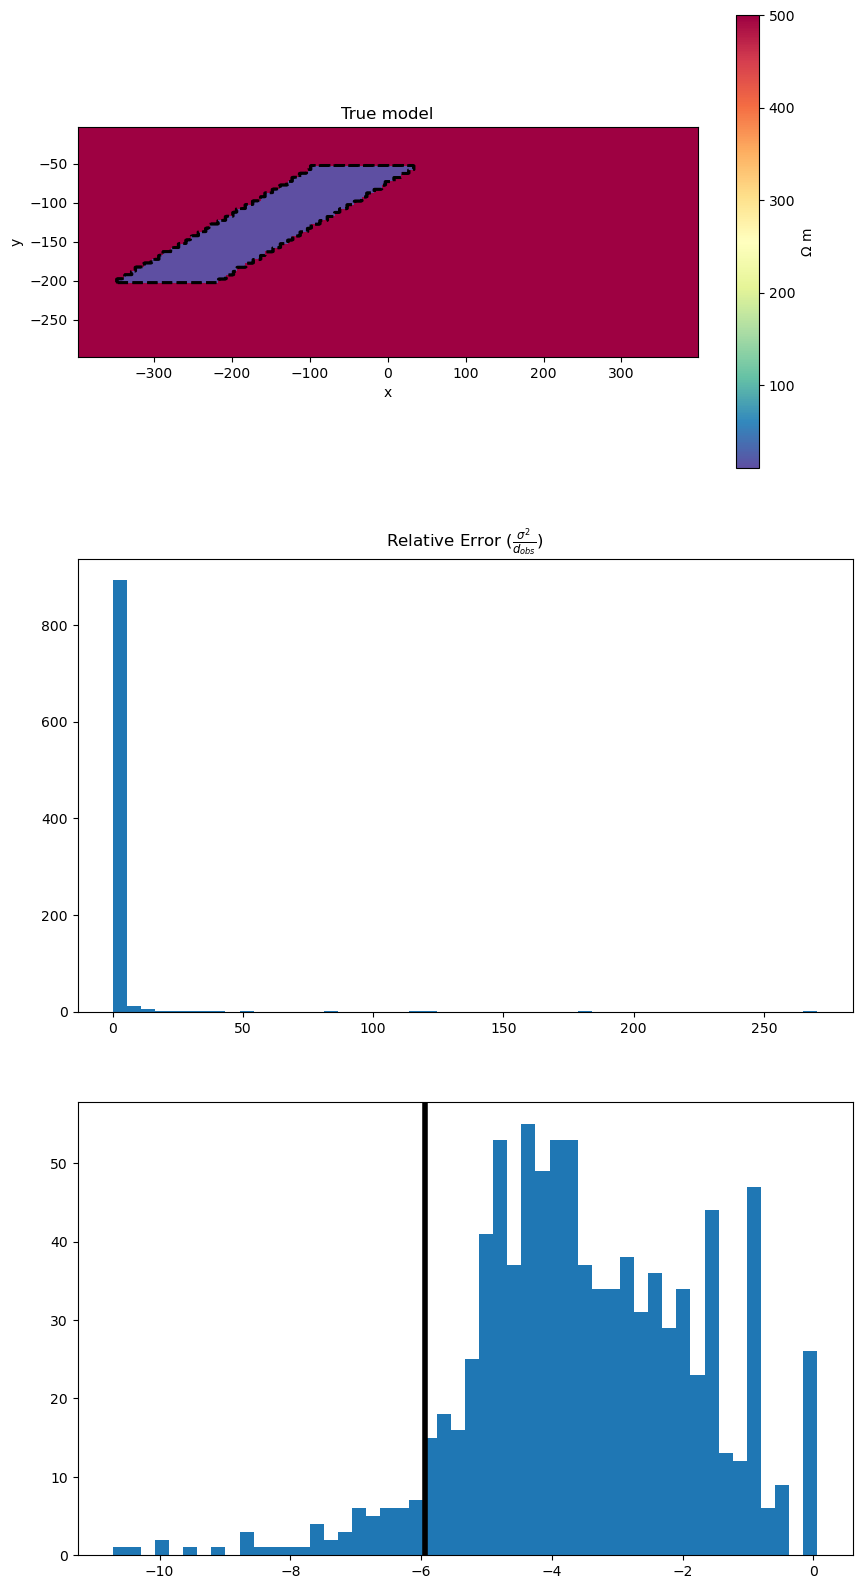

In [2]:
# -------------------------------------------------------------------------------------------------

# create a 2d mesh for a dc simulation

#

#2D mesh
csx,  csy,  csz = 5.,  5.,  5.
# Number of core cells in each direction
ncx,  ncz = 163,  61
# Number of padding cells to add in each direction
npad = 12
# Vectors of cell lengthts in each direction
hx = [(csx, npad,  -1.5), (csx, ncx), (csx, npad,  1.5)]
hz = [(csz, npad, -1.5), (csz, ncz)]
# Create mesh
mesh = discretize.TensorMesh([hx,  hz], x0="CN")
mesh.x0[1] = mesh.x0[1] + csz / 2.

print(mesh)

# -----------------------------------------------------------------------

# create a synthetic model for a dc simulation

#

model = 3 * np.ones(mesh.nC, dtype='int64')

# divide domain by  45* fault at 100 m
fault_function = lambda x, slope, shift: slope * x + shift

# Dike 30*
dike0 = mesh.gridCC[:,1] > fault_function(
    mesh.gridCC[:,0], np.tan(30 * np.pi / 180), -75)
dike1 = mesh.gridCC[:,1] < fault_function(
    mesh.gridCC[:,0], np.tan(30 * np.pi / 180), 0)
dike = np.logical_and(dike0,dike1)

model[dike]=4

# plot
fig,ax = plt.subplots(3, 1,figsize=(10,20))
mm1 = mesh.plotImage(model, ax=ax[0], pcolorOpts={'cmap':'Spectral_r'})

ax[0].set_xlim([-1000,1000])
ax[0].set_ylim([-250,0])
# ax[0].set_aspect(2)
# plt.colorbar(mm1[0])


# define conductivities
res_true = np.ones(mesh.nC)
res_true[model==3]= 500
res_true[model==4]= 10

index_deep = mesh.gridCC[:, 1] >= -50

index_deeper = mesh.gridCC[:, 1] < -200

res_true[index_deep] = 500
res_true[index_deeper] = 500

cond_true = 1./res_true

mtrue = np.log(cond_true)

xmin, xmax = -400., 400.
ymin, ymax = -300., 0.
zmin, zmax = 0, 0
xyzlim = np.r_[[[xmin, xmax], [ymin, ymax]]]
actcore,  meshCore = utils.mesh_utils.extract_core_mesh(xyzlim, mesh)
actind = np.ones_like(actcore)

# plot
mm = meshCore.plot_image(
    
    1/(cond_true)[actcore],
    ax=ax[0],
    pcolorOpts={'cmap':'Spectral_r'}

)

utils.plot2Ddata(

    meshCore.gridCC,mtrue[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[0],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)
#plt.gca().set_ylim([-200,0])
ax[0].set_aspect(1)
plt.colorbar(mm[0], label=r'$\Omega$ m')
ax[0].set_title('True model')

xmin, xmax = -350., 350.
ymin, ymax = 0., 0.
zmin, zmax = 0, 0

endl = np.array([[xmin, ymin, zmin], [xmax, ymax, zmax]])
srclist = []

for dipole in np.linspace(25,250,10):
    
    survey1 = dcutils.generate_dcip_survey(
        
        endl, survey_type="pole-dipole",
        dim=mesh.dim,
        a=dipole,
        b=dipole,
        n=16,
    
    )

    # print(dipole)

    survey2 = dcutils.generate_dcip_survey(
        
        endl, survey_type="dipole-pole",
        dim=mesh.dim,
        a=dipole,
        b=dipole,
        n=16,
    
    )
    
    srclist +=(survey1.source_list)
    srclist +=(survey2.source_list)

survey = dc.Survey(srclist)

# Setup Problem with exponential mapping and Active cells only in the core mesh
expmap = maps.ExpMap(mesh)
mapactive = maps.InjectActiveCells(
    
    mesh=mesh,
    indActive=actcore,
    valInactive=-np.log(100)

)
mapping = expmap * mapactive
simulation = dc.Simulation2DNodal(
    
    mesh, 
    survey=survey, 
    sigmaMap=mapping,
    solver=Solver,
    nky=8

)

# -----------------------------------------------------------------------

# create synthetic data and view psuedo-section

#

relative_measurement_error = 0.01
dc_data = simulation.make_synthetic_data(
    
    mtrue[actcore],
    relative_error=relative_measurement_error,
    noise_floor=6e-3,
    force=True,
    add_noise=True,

)

# dc_data.noise_floor = np.quantile(np.abs(dc_data.dobs), 0.1)

relative_error_list = (np.abs(dc_data.standard_deviation/dc_data.dobs))
print(relative_error_list.min())
print(relative_error_list.max())
print(np.median(relative_error_list), np.quantile(np.abs(dc_data.dobs), 0.06))
print(relative_error_list.mean())
ax[1].hist(relative_error_list, 50)
ax[2].hist(np.log(np.abs(dc_data.dobs)), 50)
ax[2].axvline(np.log(np.quantile(np.abs(dc_data.dobs), 0.06)), color='k', linewidth=4)
ax[1].set_title(r'Relative Error ($\frac{\sigma^{2}}{d_{obs}}$)')

In [3]:
import numpy as np

def rotation_matrix(angle):
    theta = np.radians(angle)
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    return np.array([[cos_theta, -sin_theta], [sin_theta, cos_theta]])

# Example usage
angle = 135  # Rotation angle in degrees
rot_matrix = rotation_matrix(angle)
print(rot_matrix)
print(f'principle axis: {1/rot_matrix[1, :]}, {1/rot_matrix[0, :]}')
print(np.array([[sqrt2, -sqrt2], [-sqrt2, -sqrt2],]), np.sqrt(2))


[[-0.70710678 -0.70710678]
 [ 0.70710678 -0.70710678]]
principle axis: [ 1.41421356 -1.41421356], [-1.41421356 -1.41421356]


NameError: name 'sqrt2' is not defined

In [5]:
# --------------------------------------------------------------------------

# setup the inversion

#
segmentor = geoseg.SamClassificationModel(
    meshCore,
    segmentation_model_checkpoint=r"/home/juanito/Documents/trained_models/sam_vit_h_4b8939.pth"
)
# theta = -45
# rot= np.vstack([[np.cos(theta * np.pi /180), -np.sin(theta * np.pi /180)], [np.sin(theta * np.pi /180), np.cos(theta * np.pi /180)]])


dmis = data_misfit.L2DataMisfit(data=dc_data, simulation=simulation)
# dmis.w = 1 / np.abs(dc_data.dobs * 0.05 + np.quantile(np.abs(dc_data.dobs), 0.1))
m0 = np.log(1/dcutils.apparent_resistivity_from_voltage(survey, dc_data.dobs).mean()) * np.ones(mapping.nP)
# m0 = np.load(r"/home/juanito/Documents/git/jresearch/geological_segmentation/guided/model_11.npy")
# Create the regularization with GMM information
idenMap = maps.IdentityMap(nP=m0.shape[0])
wires = maps.Wires(('m', m0.shape[0]))

# # load mask
# rot_mask = np.load('rotation_block_mask_scaled.npy')

# # set the regularization
# alphas = np.ones((meshCore.n_cells, meshCore.dim))
# # alphas[rot_mask] = [125, 25]
# alphas[meshCore.cell_centers[:, 1] < 0.5] = [125, 25]
# sqrt2 = np.sqrt(2)
# # reg_cell_dirs = 1 / np.array([[sqrt2, -sqrt2], [sqrt2, sqrt2],])
# # lets just assign them to the dip structure
# # reg_cell_dirs = [np.identity(2) for _ in range(meshCore.nC)]

# # lets just assign them to the dip structure
# reg_cell_dirs = [1 / np.array([[sqrt2, sqrt2], [sqrt2, -sqrt2],]) for _ in range(meshCore.nC)]
# print(reg_cell_dirs)
# # lets expand the area we want to
# # Dike 45*
# dike00 = mesh.gridCC[:,1] > fault_function(mesh.gridCC[:,0],1, 50)
# dike01 = mesh.gridCC[:,1] < fault_function(mesh.gridCC[:,0],1, 255)
# dike_dir_reg = np.logical_and(dike00,dike01)

# # reg model
# reg_model = model.copy()

# reg_model[dike_dir_reg]=4

# # cos = np.cos(140*np.pi / 180) * 2
# # sin = np.sin(140*np.pi / 180) * 2

# for ii in range(meshCore.nC):

#     if rot_mask[ii] == 1:
#         print('adjusting')
#         # reg_cell_dirs[ii] = np.array([[cos, -sin], [sin, cos],])
#         reg_cell_dirs[ii] = 1 / np.array([[sqrt2, -sqrt2], [-sqrt2, -sqrt2],])
#         alphas[ii] = [150, 25]

reg_seg = geoseg.GeologicalSegmentation(
    meshCore, 
    reg_dirs=None,
    ortho_check=False,
)

# reg_1storder = regularization.SmoothnessFullGradient(
#     meshCore, 
#     reg_dirs=reg_cell_dirs,
#     alphas=alphas,
#     ortho_check=False,
#     reference_model=np.log(1/dcutils.apparent_resistivity_from_voltage(survey, dc_data.dobs).mean()) * np.ones(mapping.nP)
# )

reg_small = regularization.Smallness(
    mesh=meshCore,
    reference_model=np.log(1/dcutils.apparent_resistivity_from_voltage(survey, dc_data.dobs).mean()) * np.ones(mapping.nP),
)

# # Weighting
reg_org = regularization.WeightedLeastSquares(
    mesh, 
    active_cells=actcore,
    mapping=idenMap,
    reference_model=m0
)

reg_mean = reg_small + reg_seg # reg_1storder
reg_mean.multipliers = np.r_[0.00001, 10.0]
# reg_mean = reg_org
# reg_mean.alpha_s = 1e-3
# reg_mean.alpha_x = 100
# reg_mean.alpha_y = 100
# # reg_mean.mrefInSmooth = True
# reg_mean.approx_gradient = True


# Optimization
opt = optimization.ProjectedGNCG(maxIter=60, upper=np.inf, lower=-np.inf, tolCG=1E-5, maxIterLS=20, )
opt.remember('xc')

# Set the inverse problem
invProb = inverse_problem.BaseInvProblem(dmis,  reg_mean,  opt)
betaIt = directives.BetaSchedule(coolingFactor=2, coolingRate=4)
targets = directives.MultiTargetMisfits(
    TriggerSmall=True,
    TriggerTheta=False,
    verbose=True,
)
MrefInSmooth = directives.PGI_AddMrefInSmooth(verbose=True,  wait_till_stable=True, tolerance=0.0)

update_sam = segment_iter()
update_sam.segmentation_model = segmentor
plot_iter_mref = plot_mref()
plot_iter_mref.mesh = meshCore
# updateSensW = directives.UpdateSensitivityWeights(threshold=5e-1, everyIter=False)
# update_Jacobi = directives.UpdatePreconditioner()
# save_pgi = SavePGIOutput('./pgi_param')
invProb.beta = 1e-1
inv = inversion.BaseInversion(invProb,
                            directiveList=[
                                            # updateSensW,
                                            # update_sam,
                                            #  petrodir,
                                            targets, betaIt,
                                            #  MrefInSmooth,
                                            plot_iter_mref,
                                            update_sam,
                                            #  save_pgi,
                                            # update_Jacobi,
                                            ])

# Run!

# mcluster = inv.run(m0)

# np.save("rotated_model_dip.npy", mcluster)
# np.save("true_model_dip.npy", mtrue)
# # mcluster = np.load("rotated_model.npy")


TypeError: 'everyIter' property has been removed. Please use 'every_iteration'.

Text(0.5, 1.0, 'Estimated Regularization Orientations')

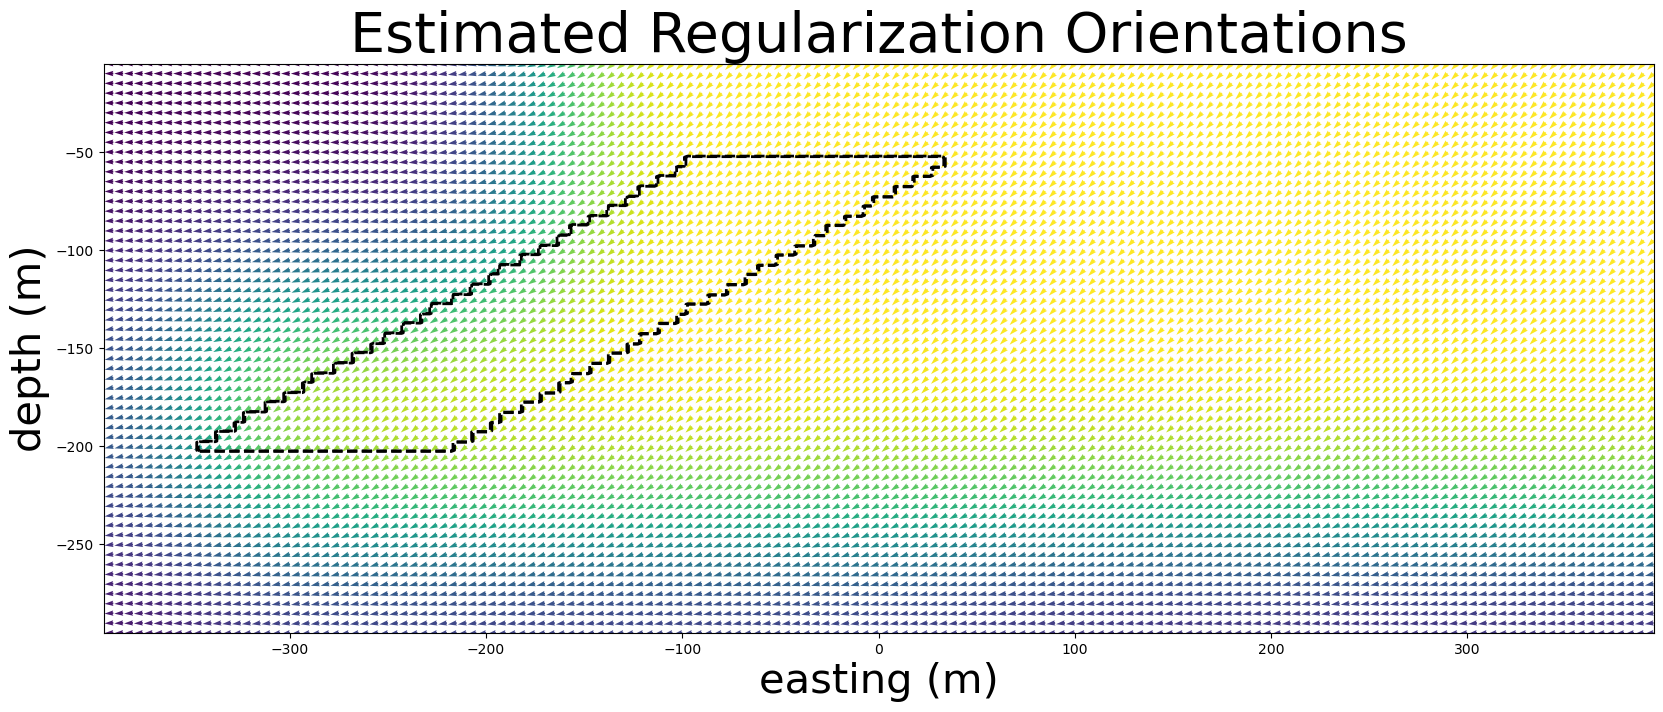

In [4]:
def plot_quiver(x, y, angles, ax=None):
    # Convert angles to radians
    angles_rad = np.radians(angles)

    # Calculate the x and y components of the vectors
    u = np.cos(angles_rad)
    v = np.sin(angles_rad)

    # Create a quiver plot
    ax.quiver(x, y, u, v, angles * 0.001)

    # Set the aspect ratio to 'equal'
    ax.axes.set_aspect('equal')

    ax.set_xlabel('easting (m)', fontsize=30)
    ax.set_ylabel('depth (m)', fontsize=30)


# Example usage
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
plot_quiver(meshCore.gridCC[:, 0], meshCore.gridCC[:, 1], update_sam.reg_rots.copy() - 90 - 180, ax=ax)

utils.plot2Ddata(

    meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax,
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)
# ax.set_xlim([-200, 100])
ax.set_title('Estimated Regularization Orientations', fontsize=40)




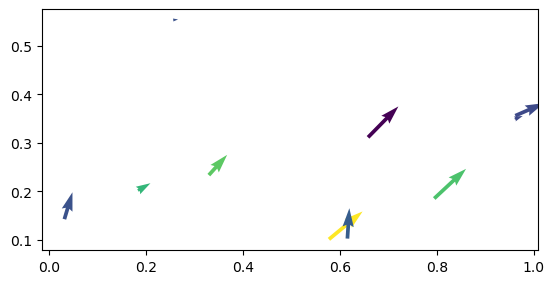

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
x = np.random.rand(10)
y = np.random.rand(10)
u = np.random.rand(10)
v = np.random.rand(10)
intensity = np.random.rand(10)  # Intensity values

# Calculate arrow lengths based on intensity
arrow_lengths = intensity * 0.1  # Adjust the scaling factor as needed

# Create a quiver plot
fig, ax = plt.subplots()
ax.quiver(x, y, u, v, arrow_lengths)

# Set the aspect ratio to 'equal'
ax.set_aspect('equal')

# Show the plot
plt.show()



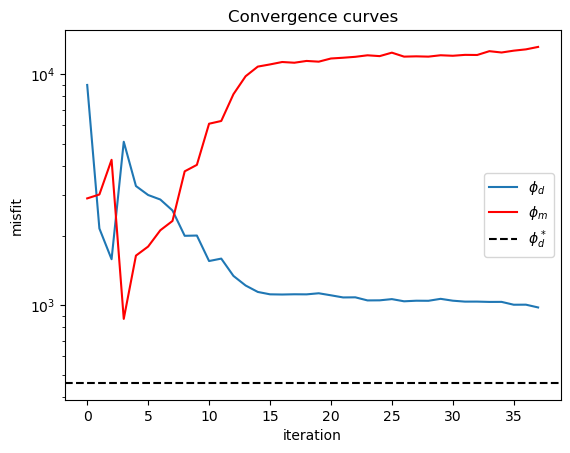

460.0


In [9]:
phi_d = []
phi_m = []
for ii in range(38):
    dip_model = np.load(f"/home/juanito/Documents/git/jresearch/geological_segmentation/iterations_adjusted_frame/model_{ii}.npy")
    phi_d.append(dmis(dip_model))
    phi_m.append(reg_mean(dip_model))

plt.semilogy(phi_d, label=r'$\phi_d$')
plt.semilogy(phi_m, 'r', label=r'$\phi_m$')
plt.axhline(dc_data.dobs.shape[0] / 2, color='k', linestyle='--', label=r'$\phi_d^*$')
plt.xlabel('iteration')
plt.ylabel('misfit')
plt.title('Convergence curves')
plt.legend()
plt.show()
print(dc_data.dobs.shape[0] / 2)

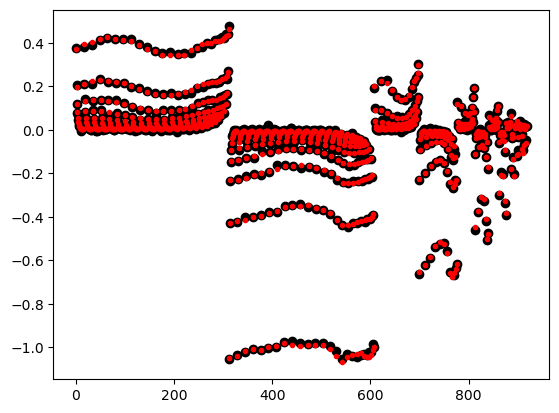

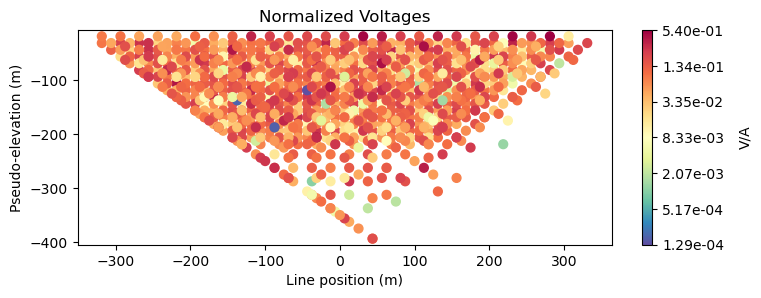

In [10]:
plt.plot(dc_data.dobs, 'ok')
plt.plot(simulation.dpred(np.log(dip_model2)), '.r')

from SimPEG.electromagnetics.static.utils.static_utils import (
    generate_dcip_sources_line,
    pseudo_locations,
    plot_pseudosection,
    apparent_resistivity_from_voltage,
)

# Plot voltages pseudo-section
fig = plt.figure(figsize=(8, 2.75))
ax1 = fig.add_axes([0.1, 0.15, 0.75, 0.78])
plot_pseudosection(
    survey,
    dobs=(simulation.dpred(dip_model) - dc_data.dobs) / np.std(dc_data.dobs)**2,
    plot_type="scatter",
    ax=ax1,
    scale="log",
    cbar_label="V/A",
    scatter_opts={"cmap": 'Spectral_r'},
)
ax1.set_title("Normalized Voltages")
plt.show()

# check comparison

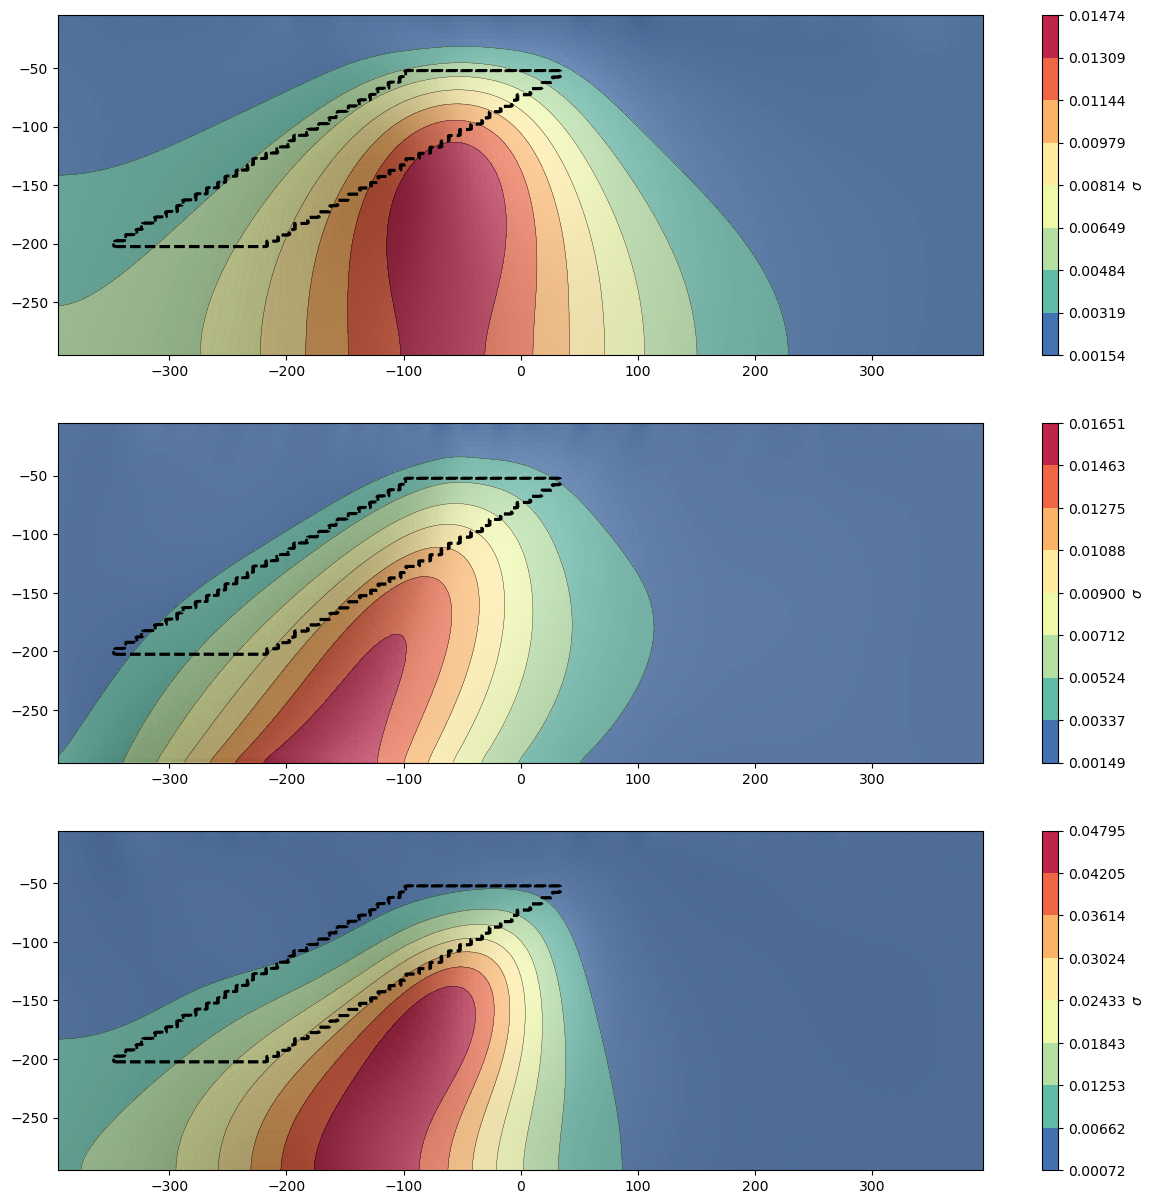

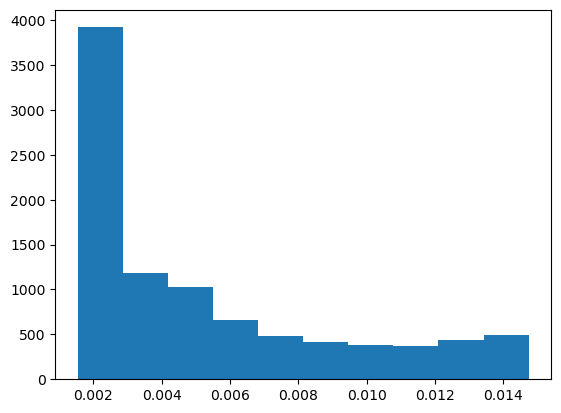

In [3]:
4# dip_model = np.exp(np.load(r"/home/juanito/git/jresearch/geological_segmentation/guided/model_11.npy"))
dip_model2 =  np.exp(np.load(r"/home/juanito/Documents/git/jresearch/geological_segmentation/iterations_adjusted_frame/model_8.npy"))
dip_model3 = np.exp(np.load(r"/home/juanito/Documents/git/jresearch/geological_segmentation/L2/model_10.npy"))
dip_model = np.exp(np.load(r"/home/juanito/Documents/git/jresearch/geological_segmentation/iterations_adjusted_frame/model_2.npy"))

fig, ax = plt.subplots(3,1, figsize=(15,15))
clim = [1 / 1000, 1/200]
mm2 = utils.plot2Ddata(

    meshCore.gridCC, dip_model3,nx=500,ny=500,
    contourOpts={'cmap':"Spectral_r", 'alpha':1},
    ax=ax[2],
    level=True,
    ncontour=8,
    shade=True,
    levelOpts={'colors':'k','linewidths':0.25},
    method='linear',
    # clim=clim,
    shade_ncontour=100,
    shade_azimuth=315.0,
    shade_angle_altitude=45.0,
    
)
plt.colorbar(mm2[0], label=r'$\sigma$')

mm = utils.plot2Ddata(

    meshCore.gridCC, dip_model,nx=500,ny=500,
    contourOpts={'cmap':"Spectral_r", 'alpha':1},
    ax=ax[0],
    level=True,
    ncontour=8,
    shade=True,
    levelOpts={'colors':'k','linewidths':0.25},
    method='linear',
    # clim=clim,
    shade_ncontour=100,
    shade_azimuth=315.0,
    shade_angle_altitude=45.0,
    
)
plt.colorbar(mm[0], label=r'$\sigma$')

utils.plot2Ddata(

    meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[1],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)

utils.plot2Ddata(

    meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[2],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)

utils.plot2Ddata(

    meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[0],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)

mm1 = utils.plot2Ddata(

    meshCore.gridCC, dip_model2,nx=500,ny=500,
    contourOpts={'cmap':"Spectral_r", 'alpha':1},
    ax=ax[1],
    level=True,
    ncontour=8,
    shade=True,
    levelOpts={'colors':'k','linewidths':0.25},
    method='linear',
    # clim=clim,
    shade_ncontour=100,
    shade_azimuth=315.0,
    shade_angle_altitude=45.0,
    
)
plt.colorbar(mm1[0], label=r'$\sigma$')



# plt.colorbar(mm[0], label=r'$\Omega$ m')
plt.show()

# fig, ax = plt.subplots(1,1)
# mm = meshCore.plot_image(
    
#     # reg_mean.deriv(dip_model),
#     reg_1storder._anis_alpha[:, 0],
#     ax=ax,
#     # clim=[-0.08, 0.08],
#     pcolorOpts={'cmap':'Spectral_r'}

# )

# plt.colorbar(mm[0], label=r'$\Omega$ m')
# plt.show()

# print(reg_org(dip_model))
# print(reg_mean(dip_model))

# plt.hist(dip_model2)
plt.hist(dip_model)
plt.show()

In [17]:
# reg_org.objfcts[0].deriv(dip_model)
np.array(phi_d) /460

array([ 4.61130546,  2.19975968,  1.6868718 , 11.45633975,  7.36975462,
        7.23269536,  6.48203778,  6.49104471,  5.81899007,  5.70906029,
        5.42928945,  4.98772421,  4.1699316 ,  3.91624053,  3.17205923,
        2.60664919,  2.30298639,  1.96839953,  1.79308113,  1.71923834,
        1.421604  ,  1.37708081,  1.27589339,  1.20228702,  1.17083057,
        1.14314852,  1.13159132,  1.10092617,  1.08654374,  1.05986125,
        1.05161032,  1.04719548,  1.03773693,  1.03190646,  1.02441129,
        1.01956297,  1.00918175,  1.00286636,  0.99656617,  1.03462994])

In [107]:
import numpy as np

def are_vectors_orthonormal(vector1, vector2, tolerance=1e-10):
    # Check if the vectors are orthogonal
    dot_product = np.dot(vector1, vector2)
    is_orthogonal = np.abs(dot_product) < tolerance

    # Check if the vectors are normalized
    magnitude_vector1 = np.linalg.norm(vector1)
    magnitude_vector2 = np.linalg.norm(vector2)
    is_normalized = np.abs(magnitude_vector1 - 1.0) < tolerance and np.abs(magnitude_vector2 - 1.0) < tolerance

    # Return True if both conditions are satisfied
    return is_orthogonal and is_normalized

# Example usage:
vector_a = np.array([sqrt2, -sqrt2])
vector_b = np.array([sqrt2, sqrt2])

if are_vectors_orthonormal(1/vector_a, 1/vector_b):
    print("The vectors are orthonormal.")
else:
    print("The vectors are not orthonormal.")
print(sqrt2, 1/sqrt2)

The vectors are orthonormal.
1.4142135623730951 0.7071067811865475


In [4]:
# model = mcluster # np.load(r"/home/juanito/Documents/git/jresearch/geological_segmentation/iterations/model_10.npy")
# dip_model3 = np.load(r"/home/juanito/Documents/git/jresearch/geological_segmentation/L2/model_10.npy")
segmentor = geoseg.SamClassificationModel(
    meshCore,
    segmentation_model_checkpoint=r"/home/juanito/Documents/trained_models/sam_vit_h_4b8939.pth"
)

masks2 = segmentor.fit(np.log(dip_model))


mask 0 vote total: 1
mask 1 vote total: 1
mask 2 vote total: 1
mask 3 vote total: 0
[1 2]
[[1.00000000e+00 3.40397783e-01 1.70726403e-01 5.78981866e-02]
 [3.40397783e-01 0.00000000e+00 5.07232704e-01 1.66981132e-01]
 [1.70726403e-01 5.07232704e-01 0.00000000e+00 3.29200248e-01]
 [5.78981866e-07 1.66981132e-06 3.29200248e-06 1.00000000e+00]]


[0, 57, 35, 18]
[0, 42, 43, 45]
[0, 17, 48, 87]


/tmp/ipykernel_8778/3345798474.py:17: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  d = meshCore.plotImage(conductivity_model_log10_true, clim=clim, ax=ax[0], pcolorOpts={'cmap':"Spectral_r"})
/tmp/ipykernel_8778/3345798474.py:41: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  d1 = meshCore.plotImage(conductivity_model_log10_true, clim=clim, ax=ax[1], pcolorOpts={'cmap':"Spectral_r"})
/tmp/ipykernel_8778/3345798474.py:76: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  d1 = meshCore.plotImage(conductivity_model_log10_true, clim=[0.5, 1], ax=ax[1], pcolorOpts={'cmap':clr[cnt - 1], 'alpha':0.2})


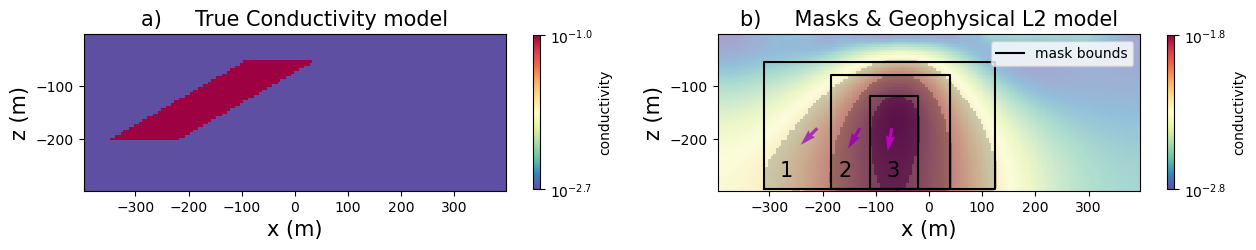

In [82]:
# np.save('iter40-segmentations.npy', masks3[2]['segmentation'])
results = masks2 #update_sam.segmentation_model.segmentations.copy()
cnt = 1

fig, ax = plt.subplots(1, 2, figsize=(15, 10))

# dat = meshCore.plotImage(1 / np.exp(dip_model), ax=ax[0, 1], clim=[10, 500], pcolorOpts={'cmap':"Spectral"})

ax[1].set_title(r'b)     Masks & Geophysical L2 model',fontsize=15)
ax[0].set_title('a)     True Conductivity model',fontsize=15)


# subplot 0,0 ----------------------------------------------------------
flatten = (cond_true)[actcore]
conductivity_model_log10_true = np.log10(np.exp(np.log(flatten)))
clim = [conductivity_model_log10_true.min(), conductivity_model_log10_true.max()]
d = meshCore.plotImage(conductivity_model_log10_true, clim=clim, ax=ax[0], pcolorOpts={'cmap':"Spectral_r"})
plt.colorbar(d[0], cmap='Spectral_r', label=r'conductivity', ticks=[clim[0],clim[1]], format="$10^{%.1f}$", shrink=0.2)
# # dat = meshCore.plotImage(1 / np.exp(flatten), ax=ax[0, 0], pcolorOpts={'cmap':"Spectral"})
# d1 = utils.plot2Ddata(

#     meshCore.gridCC, conductivity_model_log10_true,nx=500,ny=500,
#     contourOpts={'cmap':"Spectral_r", 'alpha':1},
#     ax=ax[0],
#     # level=True,
#     ncontour=5,
#     # shade=True,
#     # levelOpts={'colors':'k','linewidths':0.25},
#     method='linear',
#     # clim=clim,
#     shade_ncontour=100,
#     shade_azimuth=315.0,
#     shade_angle_altitude=45.0,
    
# )

# subplot 0,1 ----------------------------------------------------------
flatten = dip_model.flatten(order='F')
conductivity_model_log10_true = np.log10(np.exp(np.log(flatten)))
clim = [conductivity_model_log10_true.min(), conductivity_model_log10_true.max()]
d1 = meshCore.plotImage(conductivity_model_log10_true, clim=clim, ax=ax[1], pcolorOpts={'cmap':"Spectral_r"})
plt.colorbar(d1[0], cmap='Spectral_r', label=r'conductivity', ticks=[clim[0],clim[1]], format="$10^{%.1f}$", shrink=0.2)
# d1 = utils.plot2Ddata(

#     meshCore.gridCC, conductivity_model_log10_true,nx=500,ny=500,
#     contourOpts={'cmap':"Spectral_r", 'alpha':1},
#     ax=ax[1],
#     # level=True,
#     ncontour=5,
#     shade=True,
#     # levelOpts={'colors':'k','linewidths':0.25},
#     method='linear',
#     clim=[conductivity_model_log10_true.min(), conductivity_model_log10_true.max()],
#     shade_ncontour=100,
#     shade_azimuth=315.0,
#     shade_angle_altitude=45.0,
    
# )

clr = ['Purples', 'Blues', 'Greens']
clr = clr[::-1]
cnt = 0
angles = [-135, -120, -100]
angles_rad = np.radians(angles)
x_ = [-210, -130, -70]
y_ = [-180, -180, -180]
for mask in masks2[::-1]:

    if cnt < len(masks2) - 1:

        flatten = mask['segmentation'].flatten(order='F')
        conductivity_model_log10_true = flatten
        inds = conductivity_model_log10_true == 1
        conductivity_model_log10_true[inds] = -np.nan

        d1 = meshCore.plotImage(conductivity_model_log10_true, clim=[0.5, 1], ax=ax[1], pcolorOpts={'cmap':clr[cnt - 1], 'alpha':0.2})
        # d1 = utils.plot2Ddata(

        #     meshCore.gridCC, conductivity_model_log10_true,nx=500,ny=500,
        #     contourOpts={'cmap':clr[cnt - 1], 'alpha':0.4},
        #     ax=ax[1],
        #     # level=True,
        #     ncontour=5,
        #     # shade=True,
        #     # levelOpts={'colors':'k','linewidths':0.25},
        #     method='linear',
        #     clim=[0.5, 1],
        #     shade_ncontour=100,
        #     shade_azimuth=315.0,
        #     shade_angle_altitude=45.0,
            
        # )
        print(mask['bbox'])
        y0 = mask['bbox'][0] * 5 - 295
        x0 = mask['bbox'][1] * 5 - 395
        x1 = x0 + (mask['bbox'][3] * 5)
        y1 = y0 + (mask['bbox'][2] * 5)

        ax[1].plot([x0, x0, x1, x1, x0], [y0, y1, y1, y0, y0], 'k')
        # Calculate the x and y components of the vectors
        u = np.cos(angles_rad[cnt])
        v = np.sin(angles_rad[cnt])

        # Create a quiver plot
        ax[1].quiver(x_[cnt], y_[cnt], u, v, color='m') 

    cnt += 1

text1 = [-280, -270]
text2 = [-170, -270]
text3 = [-80, -270]

ax[1].text(text1[0], text1[1], '1', fontsize=15, color='k')
ax[1].text(text2[0], text2[1], '2', fontsize=15, color='k')
ax[1].text(text3[0], text3[1], '3', fontsize=15, color='k')
ax[0].axes.set_aspect('equal')
ax[1].axes.set_aspect('equal')
ax[0].set_xlabel('x (m)',fontsize=15)
ax[0].set_ylabel('z (m)',fontsize=15)
ax[1].set_xlabel('x (m)',fontsize=15)
ax[1].set_ylabel('z (m)',fontsize=15)
plt.legend(['mask bounds'], loc='upper right')


In [74]:


for result in results:
    flatten = result['segmentation'].flatten(order='F')
    reshape = flatten.reshape(meshCore.shape_cells, order='F')
    np.save(f'mask_{cnt}_dip_iter4.npy', reshape)
    plt.imshow(reshape.T)
    plt.title(f'mask: {cnt}')
    plt.gca().invert_yaxis()  
    plt.show()
    cnt += 1
print(len(result))

125

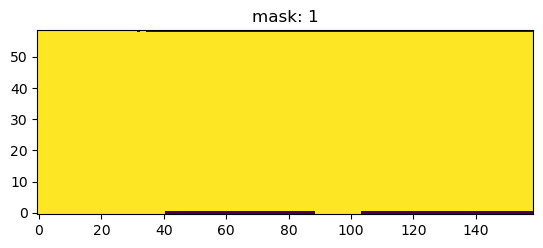

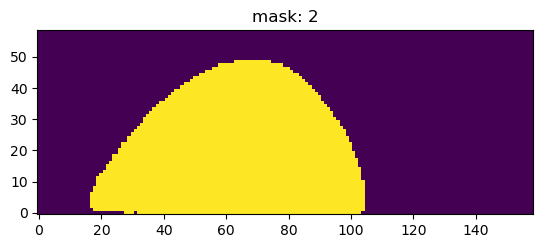

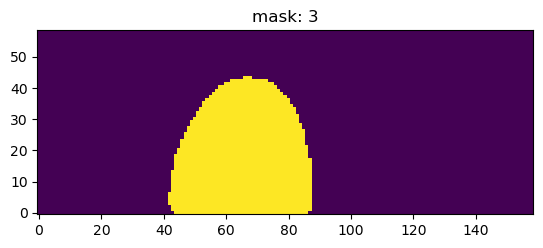

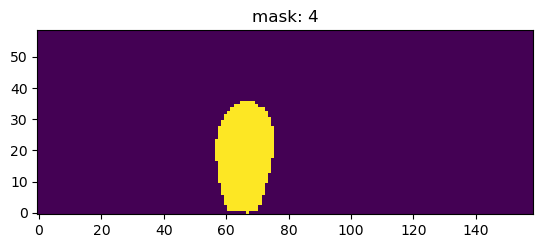

7


In [25]:
results = masks2 # update_sam.segmentation_model.segmentations.copy()
cnt = 1
for result in results:
    flatten = result['segmentation'].flatten(order='F')
    reshape = flatten.reshape(meshCore.shape_cells, order='F')
    np.save(f'mask_{cnt}_dip_iter4.npy', reshape)
    plt.imshow(reshape.T)
    plt.title(f'mask: {cnt}')
    plt.gca().invert_yaxis()  
    plt.show()
    cnt += 1
print(len(result))

# flatten = dip_model
# reshape = flatten.reshape(meshCore.shape_cells, order='F')

# plt.imshow(reshape.T, cmap='Spectral_r')
# plt.title(f'iteration: {6}',fontsize=15)
# plt.gca().invert_yaxis()
# plt.colorbar()
# plt.show()

In [7]:
masks = update_sam.segmentation_model.segmentations.copy()

mask 0: 0.9963486110240093 ohm - m
mask 1: 0.9655817828881715 ohm - m
mask 2: 0.954302153824203 ohm - m
mask 3: 0.9980207203498273 ohm - m
mask 4: 0.9980208224751996 ohm - m
mask 5: 0.9984302780473235 ohm - m
mask 6: 0.9980214996952552 ohm - m
mask 7: 0.9975418688522285 ohm - m


/tmp/ipykernel_99724/2402717301.py:5: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  dat = meshCore.plotImage(1 / geological_model, ax=ax, clim=[10, 500], pcolorOpts={'cmap':"Spectral"})
/home/juanito/mambaforge/envs/jresearch/lib/python3.11/site-packages/discretize/utils/code_utils.py:313: FutureWarning: pcolorOpts has been deprecated, please use pcolor_opts
  return getattr(self, new_name)(*args, **kwargs)


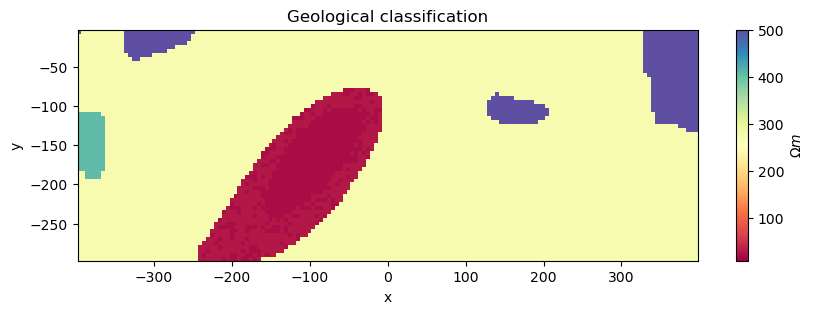

In [12]:
# masks[5]['area']
# bbox.shape
geological_model = segmentor.predict(dip_model2)
fig, ax = plt.subplots(1,1, figsize=(10, 3))
dat = meshCore.plotImage(1 / geological_model, ax=ax, clim=[10, 500], pcolorOpts={'cmap':"Spectral"})

# dat = utils.plot2Ddata(

#     meshCore.gridCC, 1 / np.exp(geological_model),nx=500,ny=500,
#     contourOpts={'cmap':"Spectral", 'alpha':1},
#     #clim=[0,5],
#     ax=ax,
#     # level=True,
#     ncontour=10,
#     # shade=True,
#     levelOpts={'colors':'k','linewidths':0.25},
#     method='linear',
#     clim=[10, 500],
#     shade_ncontour=100,
#     shade_azimuth=315.0,
#     shade_angle_altitude=45.0,
    
# )
# ax.axis("equal")
ax.set_title('Geological classification')
plt.colorbar(dat[0], label=r'$\Omega m$')

[-7.240941421590195, -3.0375676960716893]


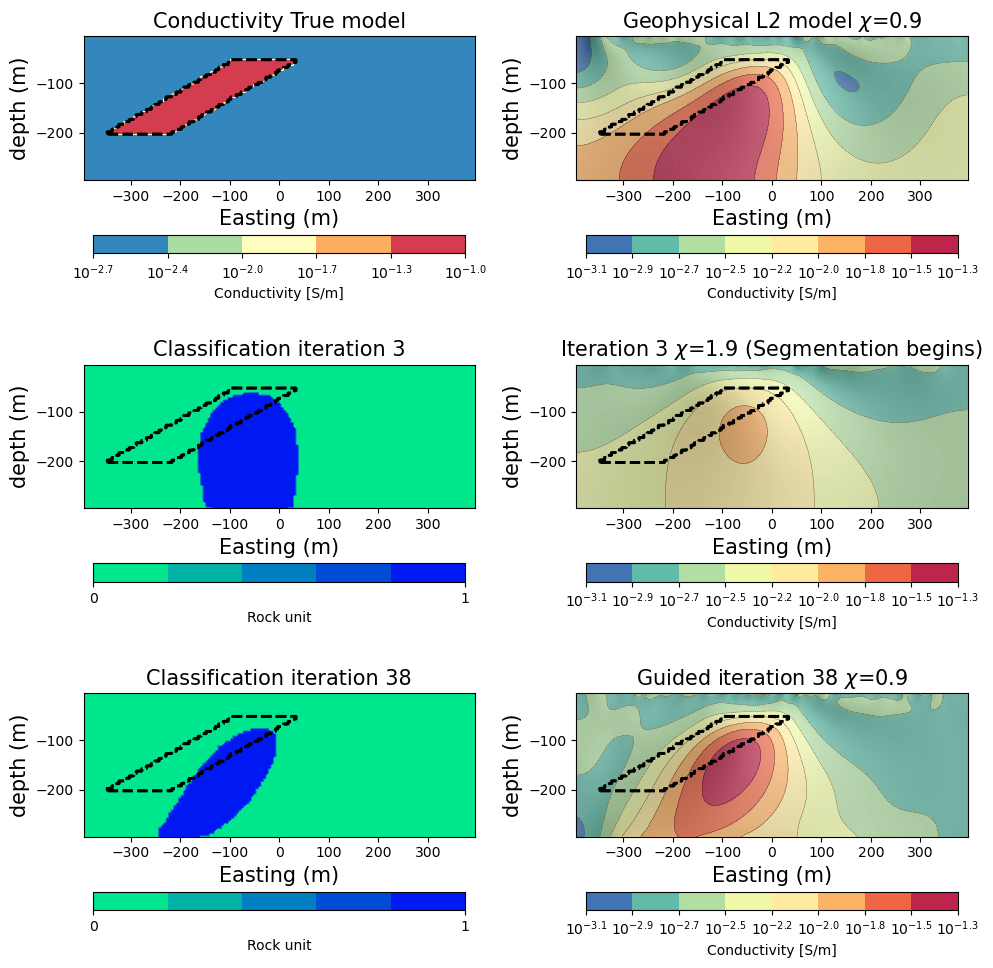

In [64]:
from matplotlib.colors import LogNorm
import matplotlib as mpl

sam_model = segmentor
masks2 = update_sam.segmentation_model.segmentations
cond_true = mtrue
fig, ax = plt.subplots(3, 2, figsize=(10, 10))

# dat = meshCore.plotImage(1 / np.exp(dip_model), ax=ax[0, 1], clim=[10, 500], pcolorOpts={'cmap':"Spectral"})

ax[0, 1].set_title(r'Geophysical L2 model $\chi$=0.9',fontsize=15)
ax[0, 1].set_xlabel('Easting (m)',fontsize=15)
ax[0, 1].set_ylabel('depth (m)',fontsize=15)


ax[0, 0].set_title('Conductivity True model',fontsize=15)
ax[0, 0].set_xlabel('Easting (m)',fontsize=15)
ax[0, 0].set_ylabel('depth (m)',fontsize=15)

ax[1, 0].set_title('Classification iteration 3',fontsize=15)
ax[1, 0].set_xlabel('Easting (m)',fontsize=15)
ax[1, 0].set_ylabel('depth (m)',fontsize=15)

# ax[1, 1].invert_yaxis()
ax[1, 1].set_title(r'Iteration 3 $\chi$=1.9 (Segmentation begins)',fontsize=15)
ax[1, 1].set_xlabel('Easting (m)',fontsize=15)
ax[1, 1].set_ylabel('depth (m)',fontsize=15)

# ax[1, 1].invert_yaxis()
ax[2, 0].set_title('Classification iteration 38',fontsize=15)
ax[2, 0].set_xlabel('Easting (m)',fontsize=15)
ax[2, 0].set_ylabel('depth (m)',fontsize=15)

# ax[1, 1].invert_yaxis()
ax[2, 1].set_title(r'Guided iteration 38 $\chi$=0.9',fontsize=15)
ax[2, 1].set_xlabel('Easting (m)',fontsize=15)
ax[2, 1].set_ylabel('depth (m)',fontsize=15)

# flatten = sam_model.masks[4]['segmentation'].flatten(order='F')
# dat = meshCore.plotImage(1 / np.exp(flatten), ax=ax[3, 0], pcolorOpts={'cmap':"winter_r"})
# # ax[1, 1].invert_yaxis()
# ax[3, 0].set_title('segmentation: 5',fontsize=15)
# ax[3, 1].axis('off')
clim = [dip_model3.min(), dip_model3.max()]
print(clim)
# subplot 0,0 ----------------------------------------------------------
flatten = (cond_true)[actcore]
conductivity_model_log10_true = np.log10(np.exp(flatten))
# dat = meshCore.plotImage(1 / np.exp(flatten), ax=ax[0, 0], pcolorOpts={'cmap':"Spectral"})
d1 = utils.plot2Ddata(

    meshCore.gridCC, conductivity_model_log10_true,nx=500,ny=500,
    contourOpts={'cmap':"Spectral_r", 'alpha':1},
    ax=ax[0, 0],
    # level=True,
    ncontour=5,
    # shade=True,
    # levelOpts={'colors':'k','linewidths':0.25},
    method='linear',
    # clim=clim,
    shade_ncontour=100,
    shade_azimuth=315.0,
    shade_angle_altitude=45.0,
    
)

utils.plot2Ddata(

    meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[0, 0],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)

norm = mpl.colors.Normalize(
    vmin=conductivity_model_log10_true.min(), vmax=conductivity_model_log10_true.max()
)

plt.colorbar(d1[0], cmap='Spectral_r', norm=norm, orientation="horizontal", label='Conductivity [S/m]', format="$10^{%.1f}$", pad=0.2, shrink=0.95)


# subplot 0,1 ----------------------------------------------------------

utils.plot2Ddata(

    meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[0, 1],
    level=True,
    ncontour=2,
    # shade=True,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)

dip_model3 = np.load(r"/home/juanito/Documents/git/jresearch/geological_segmentation/L2/model_10.npy")
conductivity_model_log10 = np.log10(np.exp(dip_model3))
clim = [conductivity_model_log10.min(), conductivity_model_log10.max()]
d2 = utils.plot2Ddata(

    meshCore.gridCC, conductivity_model_log10, nx=500,ny=500,
    contourOpts={'cmap':"Spectral_r", 'alpha':1},
    ax=ax[0, 1],
    level=True,
    ncontour=8,
    shade=True,
    levelOpts={'colors':'k','linewidths':0.25},
    method='linear',
    clim=clim,
    shade_ncontour=100,
    shade_azimuth=315.0,
    shade_angle_altitude=45.0,
    
)

norm = mpl.colors.Normalize(
    vmin=conductivity_model_log10.min(), vmax=conductivity_model_log10.max()
)

plt.colorbar(d2[0], cmap='Spectral_r', norm=norm, orientation="horizontal", label='Conductivity [S/m]', format="$10^{%.1f}$", pad=0.2, shrink=0.95)

# subplot 1,0 ----------------------------------------------------------

flatten = masks[2]['segmentation'].flatten(order='F')  # np.load('iter40-segmentations.npy').astype(int).flatten(order='F')

utils.plot2Ddata(

    meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    ax=ax[1, 0],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)

d3 = utils.plot2Ddata(

    meshCore.gridCC, flatten,nx=500,ny=500,
    contourOpts={'cmap':"winter_r", 'alpha':1},
    ax=ax[1, 0],
    level=False,
    ncontour=5,
    # shade=True,
    levelOpts={'colors':'k','linewidths':0.25},
    method='linear',
    # clim=[10, 500],
    
)

# norm_seg = mpl.colors.Normalize(
#     vmin=conductivity_model_log10_seg.min(), vmax=conductivity_model_log10_seg.max()
# )

plt.colorbar(d3[0], cmap='winter_r', orientation="horizontal", label='Rock unit', ticks=[0,1], pad=0.2, shrink=0.95)

# subplot 1,1 ----------------------------------------------------------

utils.plot2Ddata(

    meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[1, 1],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)

dip_model1_1 = np.load(r"/home/juanito/Documents/git/jresearch/geological_segmentation/iterations/model_2.npy")
conductivity_model_log10_1_1 = np.log10(np.exp(dip_model1_1))
d5 = utils.plot2Ddata(

    meshCore.gridCC, conductivity_model_log10_1_1,nx=500,ny=500,
    contourOpts={'cmap':"Spectral_r", 'alpha':1},
    ax=ax[1, 1],
    level=True,
    ncontour=8,
    shade=True,
    levelOpts={'colors':'k','linewidths':0.25},
    method='linear',
    clim=clim,
    shade_ncontour=100,
    shade_azimuth=315.0,
    shade_angle_altitude=45.0,
    
)

# norm = mpl.colors.Normalize(
#     vmin=conductivity_model_log10_seg.min(), vmax=conductivity_model_log10_seg.max()
# )

plt.colorbar(d5[0], cmap='Spectral_r', norm=norm, orientation="horizontal", label='Conductivity [S/m]', format="$10^{%.1f}$", pad=0.2, shrink=0.95)

# subplot 2,0 ----------------------------------------------------------

utils.plot2Ddata(

    meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[2, 0],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)

flatten = masks2[1]['segmentation'].flatten(order='F')
d6 = utils.plot2Ddata(

    meshCore.gridCC, flatten,nx=500,ny=500,
    contourOpts={'cmap':"winter_r", 'alpha':1},
    #clim=[0,5],
    ax=ax[2, 0],
    level=False,
    ncontour=5,
    # shade=True,
    levelOpts={'colors':'k','linewidths':0.25},
    method='linear',
    # clim=[10, 500],
    
)
plt.colorbar(d6[0], cmap='winter_r', orientation="horizontal", label='Rock unit', ticks=[0,1], pad=0.2, shrink=0.95)

# subplot 2,1 ----------------------------------------------------------

utils.plot2Ddata(

    meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[2, 1],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)

# flatten = masks3[3]['segmentation'].flatten(order='F')
dip_model2_1 = np.load(r"/home/juanito/Documents/git/jresearch/geological_segmentation/iterations/model_39.npy")
conductivity_model_log10_2_1 = np.log10(np.exp(dip_model2_1))
d7 = utils.plot2Ddata(

    meshCore.gridCC, conductivity_model_log10_2_1,nx=500,ny=500,
    contourOpts={'cmap':"Spectral_r", 'alpha':1},
    ax=ax[2, 1],
    level=True,
    ncontour=8,
    shade=True,
    levelOpts={'colors':'k','linewidths':0.25},
    method='linear',
    clim=clim,
    shade_ncontour=100,
    shade_azimuth=315.0,
    shade_angle_altitude=45.0,
    
)
plt.colorbar(d7[0], cmap='Spectral_r', norm=norm, orientation="horizontal", label='Conductivity [S/m]', format="$10^{%.1f}$", pad=0.2, shrink=0.95)

plt.tight_layout()

23.47826086956522

# angles

In [21]:
seg_data = masks2[-1]['segmentation']  # results[2]['segmentation']
seg_data = np.flip(seg_data)
# Find the coordinates of the object pixels
object_pixels = np.argwhere(seg_data == 1)

# Apply PPCA to determine orientation
if len(object_pixels) > 1:
    # Standardize the data
    scaler = StandardScaler()
    object_pixels_std = scaler.fit_transform(object_pixels)

    # Apply PPCA
    pca = PCA(n_components=2)
    pca.fit(object_pixels_std)

    # The first principal component (eigenvector) will represent the orientation
    orientation_vector = pca.components_[0]

    # Compute the angle of the orientation vector (in degrees)
    angle_degrees = np.arctan2(orientation_vector[1], orientation_vector[0]) * 180 / np.pi

    print(f"Orientation angle (degrees): {angle_degrees}")
    angle_radians = angle_degrees * np.pi / 180

Orientation angle (degrees): 44.99999999999996


In [22]:
orientation_vector

array([0.70710678, 0.70710678])

# Bounding box

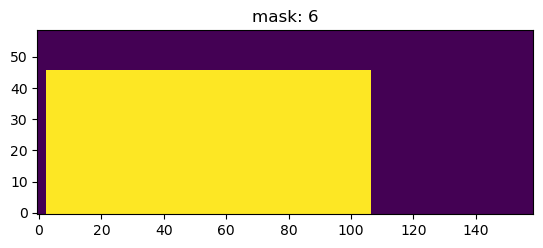

In [28]:
ii = 1
a = 0
b = 20
# masks = results
y0 = masks[ii]['bbox'][0] - a
x0 = masks[ii]['bbox'][1] - b
x1 = x0 + masks[ii]['bbox'][3] + b
y1 = y0 + masks[ii]['bbox'][2] + a

# generate as sparse matrix when things get big
bbox = np.zeros(masks[ii]['segmentation'].shape)

bbox[x0:x1, y0:y1] = 1
# bbox[x1, y1] = 1

flatten = bbox # masks[ii]['segmentation'].flatten(order='F')
reshape = flatten.reshape(meshCore.shape_cells, order='F')

plt.imshow(reshape.T)
plt.title(f'mask: {cnt + 1}')
plt.gca().invert_yaxis()
# plt.plot([x0, x1], [y0, y1], 'ok')
plt.show()

In [32]:
masks[ii]['bbox']

[0, 32, 42, 63]

/tmp/ipykernel_149691/3900165161.py:4: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  dat = meshCore.plotImage(1 / np.exp(flatten), ax=ax, pcolorOpts={'cmap':"winter_r"})


(<matplotlib.contour.QuadContourSet at 0x772013fb5410>,
 <Axes: title={'center': 'Segmentation Mask 2: Bounding box'}, xlabel='x', ylabel='y'>,
 <matplotlib.contour.QuadContourSet at 0x772013bcd550>)

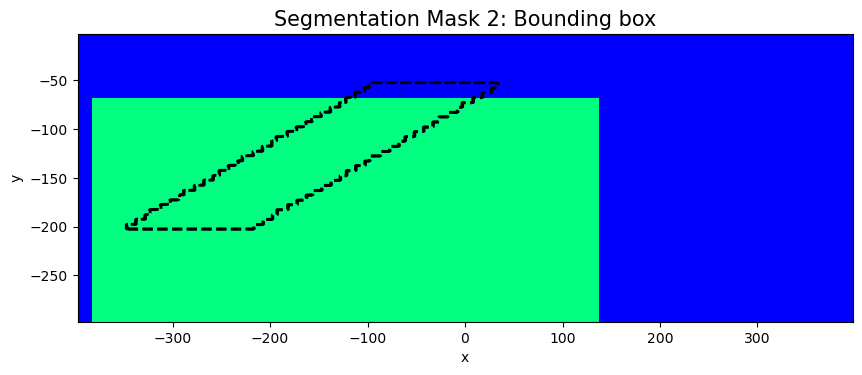

In [30]:
fig, ax = plt.subplots(1,1, figsize=(10, 5))
# dat = meshCore.plotImage(1 / np.exp(geological_model), ax=ax, clim=[10, 500], pcolorOpts={'cmap':"Spectral"})
flatten = reshape.flatten(order='F')  # (cond_true)[actcore]
dat = meshCore.plotImage(1 / np.exp(flatten), ax=ax, pcolorOpts={'cmap':"winter_r"})
ax.set_title(f'Segmentation Mask {ii+1}: Bounding box',fontsize=15)
# plt.colorbar(dat[0])

utils.plot2Ddata(

    meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax,
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)

In [27]:
np.save('rotation_block_mask_scaled.npy', flatten)

In [19]:
flatten.shape

(9381,)

# Doug and Yaoguo's paper

In [ ]:
from scipy.sparse import diags
dip_model = np.load(r"/home/juanito/git/jresearch/geological_segmentation/iterations/model_6.npy")


theta = 45 * np.pi / 180

# X term ------------------------------------------------------------------------------
alpha_rot_x = alphas[:, 0] * np.cos(theta)**2 + alphas[:, 1] * np.sin(theta)**2
average_cell_to_face_x = meshCore.average_cell_to_face[: meshCore.nFx]

a = meshCore.face_x_areas
v = average_cell_to_face_x @ meshCore.cell_volumes
cell_gradient_x = sp.diags(a / v) @ meshCore.stencil_cell_gradient_x

r = cell_gradient_x @ (reg_mean.mapping * (reg_mean._delta_m(dip_model)))

# M_f = meshCore.get_face_inner_product(alpha_rot)
bx = average_cell_to_face_x @ alpha_rot_x

# phix = r[:, None].T @ diags(bx) @ r[:, None]
# print(phix, r[:, None].shape, bx.shape)

# Y term ------------------------------------------------------------------------------
alpha_rot_y = alphas[:, 0] * np.sin(theta)**2 + alphas[:, 1] * np.cos(theta)**2
average_cell_to_face_y = meshCore.average_cell_to_face[
    meshCore.nFx:(meshCore.nFx + meshCore.nFy)
]

a = meshCore.face_y_areas
v = average_cell_to_face_y @ meshCore.cell_volumes
cell_gradient_y = sp.diags(a / v) @ meshCore.stencil_cell_gradient_y

r = cell_gradient_y @ (reg_mean.mapping * (reg_mean._delta_m(dip_model)))

# M_f = meshCore.get_face_inner_product(alpha_rot)
by = average_cell_to_face_y @ alpha_rot_y

# phiy = r[:, None].T @ diags(by) @ r[:, None]


# XY term ------------------------------------------------------------------------------
alpha_rot_xy = (alphas[:, 0] - alphas[:, 1]) * np.sin(theta) * np.cos(theta)
print(phiy, r[:, None].shape, by.shape, alpha_rot_xy.shape, meshCore.nC)
# average_cell_to_face_xy = meshCore.average_cell_to_face[:(meshCore.nFx + meshCore.nFy)
# ]

ax = meshCore.face_x_areas
vx = average_cell_to_face_x @ meshCore.cell_volumes
cell_gradient_x = sp.diags(ax / vx) @ meshCore.stencil_cell_gradient_x

ay = meshCore.face_y_areas
vy = average_cell_to_face_y @ meshCore.cell_volumes
cell_gradient_y = sp.diags(ay / vy) @ meshCore.stencil_cell_gradient_y

rx = cell_gradient_x @ (reg_mean.mapping * (reg_mean._delta_m(dip_model)))
ry = cell_gradient_y @ (reg_mean.mapping * (reg_mean._delta_m(dip_model)))

# M_f = meshCore.get_face_inner_product(alpha_rot)
# bxy1 = average_cell_to_face_x @ alpha_rot_xy
# bxy2 = average_cell_to_face_y @ alpha_rot_xy
print(cell_gradient_x.shape, cell_gradient_y.shape, diags(alpha_rot_xy).shape)
# phixy = rx[:, None].T @ diags(alpha_rot_xy) @ ry[:, None] #  + ry[:, None].T @ diags(bxy2) @ rx[:, None]
# print(phixy)

# a1 = sp.kron(average_cell_to_face_y, average_cell_to_face_x)

# construct whole thing
Gxz1 = cell_gradient_x @ diags(alpha_rot_xy) @ cell_gradient_y.T # + cell_gradient_y @ diags(alpha_rot_xy) @ cell_gradient_x.T
print(Gxz1.shape) 